In [1]:
# -*- coding: utf-8 -*-
"""dna-classification-vcu.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/13BLlKCJc5EiKMHP7KEH5hOXyLEIUdX02

# DNA Multi Class Classification
"""


"""## Prepare Google Drive"""

# Run this cell to mount your Google Drive.

local_path = './'

"""## Prepare fastai"""
from fastai import *
from fastai.text import *

"""## Prepare Dataset"""

local_project_path = local_path + 'dna-10class/'

if not os.path.exists(local_project_path):
  os.makedirs(local_project_path)
  
print('local_project_path:', local_project_path)
"""## Create Language Model"""

class dna_tokenizer(BaseTokenizer):
  def tokenizer(slef, t):
    return list(t)

tokenizer = Tokenizer(tok_func=dna_tokenizer, pre_rules=[], post_rules=[], special_cases=[])
processor = [TokenizeProcessor(tokenizer=tokenizer, include_bos= False, include_eos=False), NumericalizeProcessor(max_vocab=30000)]

# batch size
bs = 64

data_lm = TextLMDataBunch.from_csv(local_project_path, 'combined.csv',
                                   text_cols ='Text', valid_pct= 0.1, tokenizer=tokenizer,
                                   include_bos= False, include_eos=False)
# learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained=False).to_fp16()
# learn.load('lm-fine-tuned-10-6')
# learn.save_encoder('lm-fine-tuned-10-6-encoder')

"""## Create Classifier"""
# data_cls = TextClasDataBunch.from_csv(local_project_path, 'combined_train.csv',
#                                    text_cols ='Text', label_cols ='class', valid_pct= 0.1, tokenizer=tokenizer,
#                                    include_bos= False, include_eos=False, vocab = data_lm.vocab)
data_cls = (TextList.from_csv(local_project_path, 'combined.csv', cols='Text', vocab=data_lm.vocab, processor= processor)
                   .split_from_df(col='is_test')
                   .label_from_df(cols='class')
                   .databunch(bs=bs))

print('data_cls validation set size', len(data_cls.valid_ds))
# data_cls.show_batch()

learn_cls = text_classifier_learner(data_cls, AWD_LSTM, drop_mult=0.3, pretrained=False)#.to_fp16()

data_cls validation set size 5314


In [14]:
from fastai.metrics import *

In [2]:
learn_cls.load('fifth');

In [3]:
dna_string = 'atggcagtggcaggtaaaaatgactttgcagttctcaacaccgggcggaagatgcctctccttgggctgggaacatggaagagtgaacctggcaaggttaaacaggcagtaatctgggccttgcaggctggctaccgccacttcgactgtgctgccatctatggcaacgagttggagatcggagaagctctgcaggagacacttggccctgacaaagccttgaggcgagaggatgtgtttatcacctccaagctgtggaacacacagcatcacccggaggatgtggagcccgctctgctgaagacactgaaggagctgagtctggaatacctggatctatacctcatccactggccctatgccttccaacaaggtgacgctcctttccccaaatcggaggacggcaccctgctgtacgacgacatcgactacaagctgacttgggctgccatggagaagctggtgggaaagggcctggtcagggctatcggcctgtccaacttcaacagcaaacagatagacaacgttctctccgtagccaacatcaaaccgactgtgcttcaggtggaaagccatccgtatctggctcaggtggagttgctgggacactgccgggacagaggcctggtgattacagcgtacagcccactggggtcaccggatcgggtatggaagcatcctgatgagcccgtcctcctggatgaagcagcaatcgacaccctggccaagaagtacaacaagtccccagcacaaatcatccttagatggcagacacagcgaggagtagtgacgatccctaaaagtgtgacagagtctcggatcaaagagaatattcaggtatttgactttacccttgaagcggaagagatgaagtgtataacagcattgaacagaggctggcgctacattgtaccaaccatcacagttgatgggaagcccgtccccagggatgcaggacatccacactaccccttcagtgacccctactga'
res = learn_cls.predict(dna_string)
print(res)


(Category 1.1.1.2, tensor(0), tensor([1.0000e+00, 5.5785e-12, 7.2571e-10, 2.2010e-10, 2.3871e-11, 2.1388e-10,
        7.2346e-11, 1.3818e-08, 1.9142e-07, 8.8164e-09]))


In [ ]:
interp = ClassificationInterpretation.from_learner(learn_cls)

losses,idxs = interp.top_losses()

In [6]:
len(data_cls.valid_ds)==len(losses)==len(idxs)

True

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

AttributeError: 'ClassificationInterpretation' object has no attribute 'plot_top_losses'

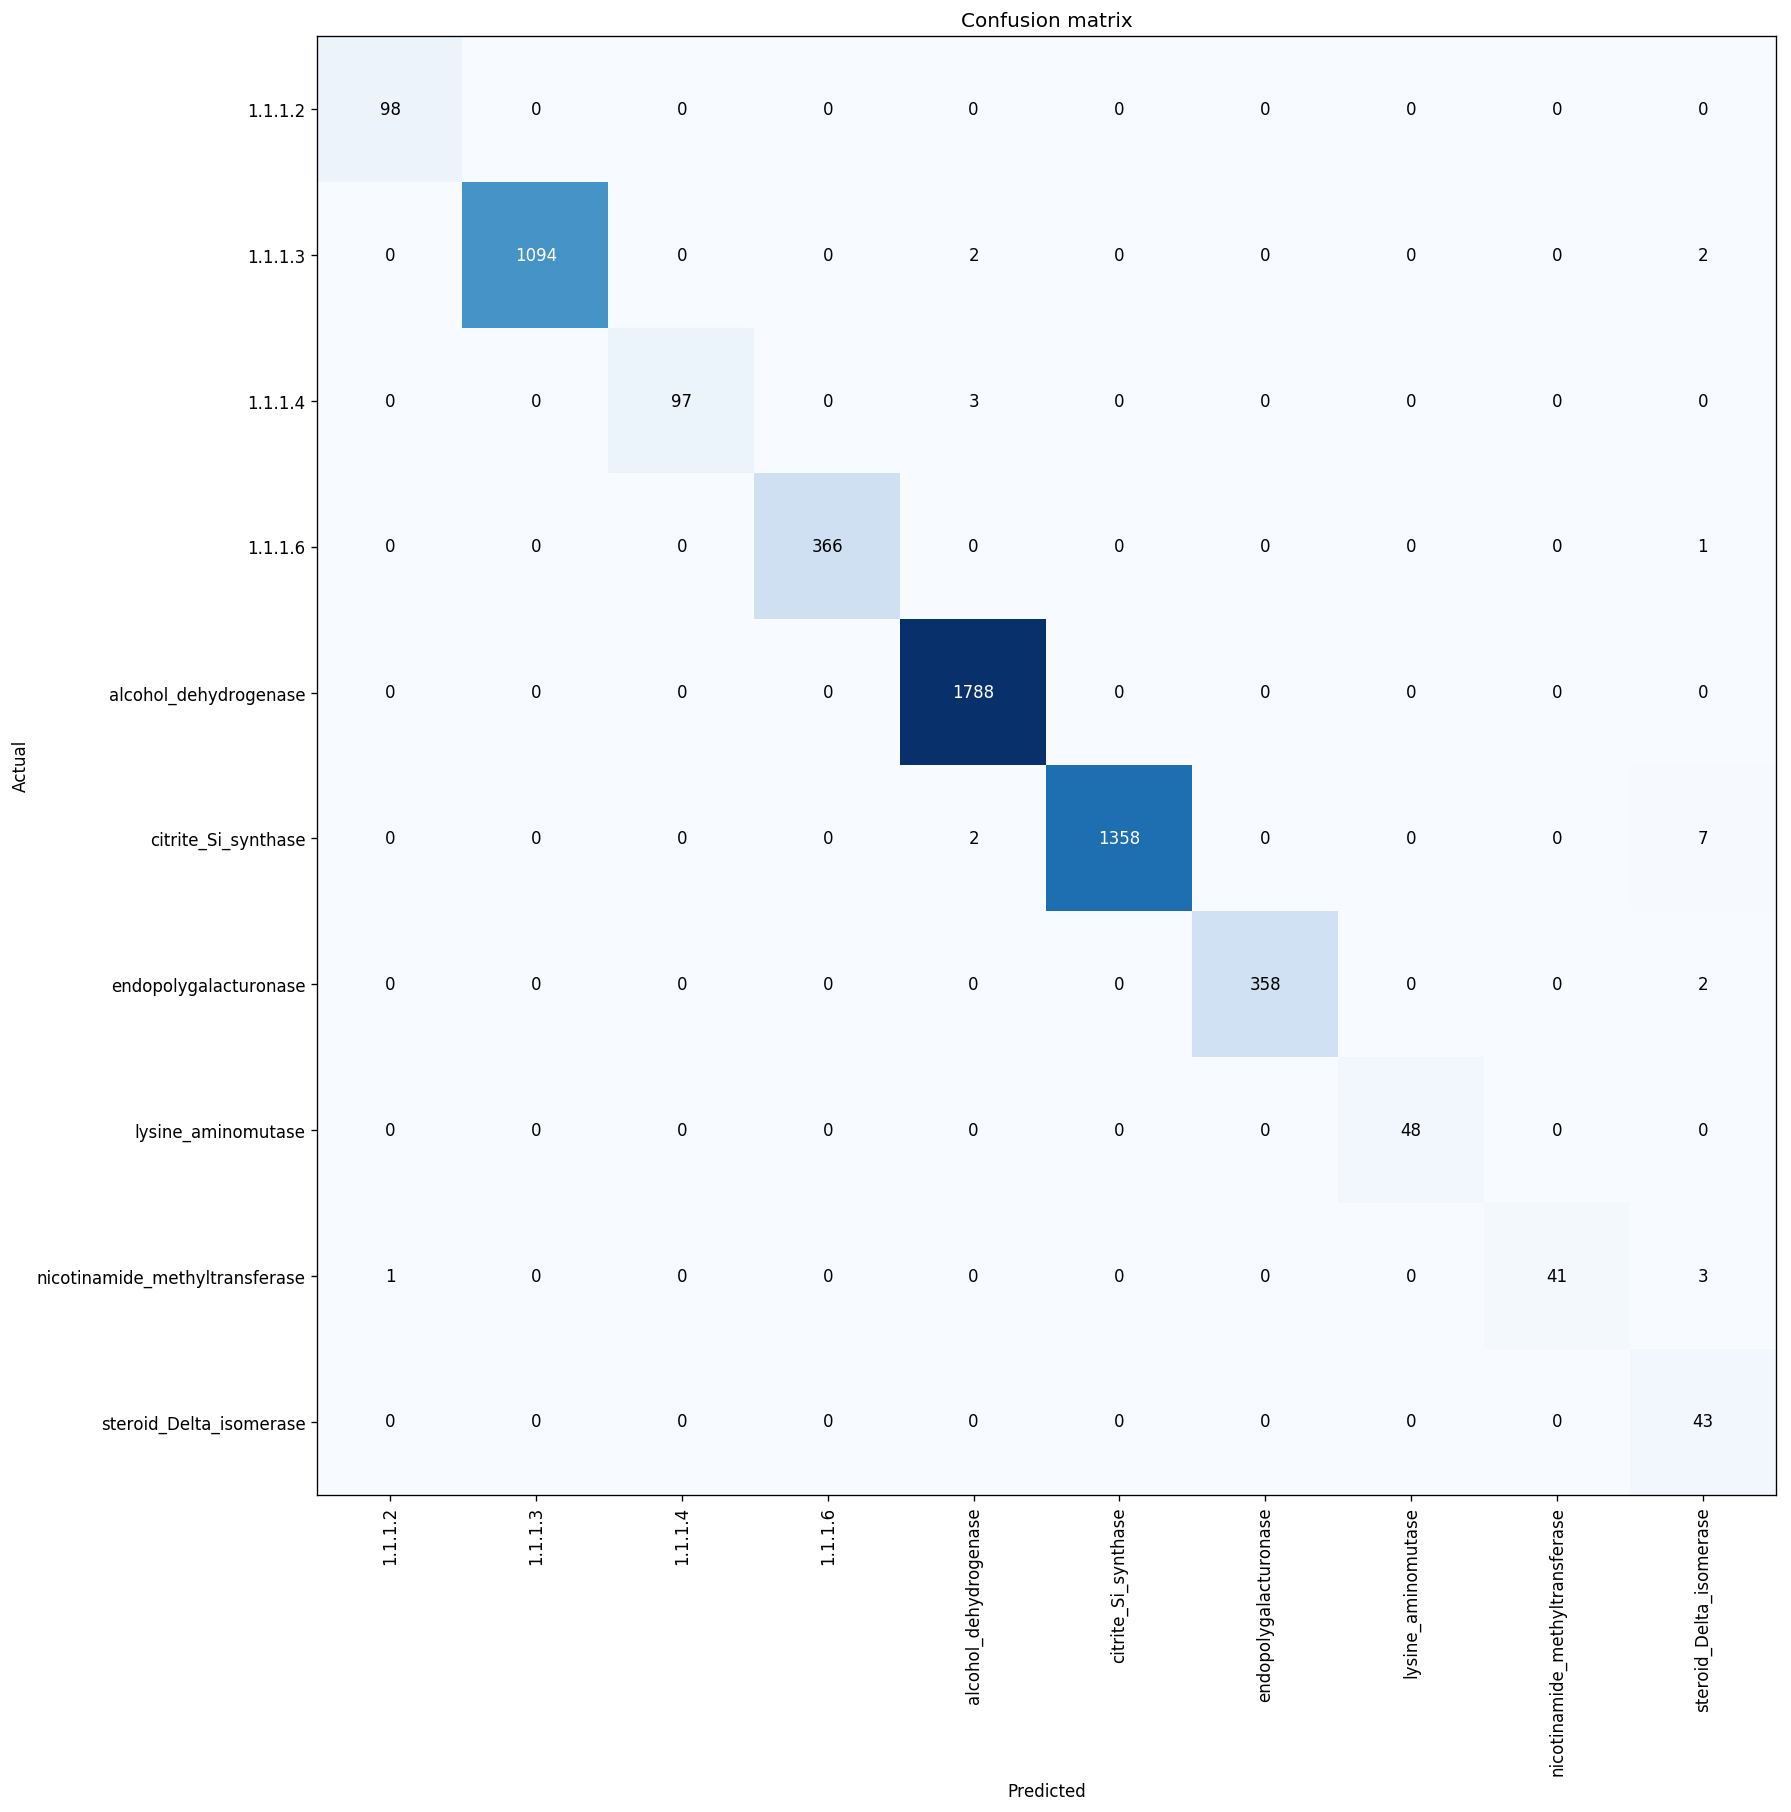

In [19]:
interp.plot_confusion_matrix(figsize=(15,15), dpi=120)

In [9]:
interp.most_confused(min_val=2)

[('citrite_Si_synthase', 'steroid_Delta_isomerase', 7),
 ('1.1.1.4', 'alcohol_dehydrogenase', 3),
 ('nicotinamide_methyltransferase', 'steroid_Delta_isomerase', 3),
 ('1.1.1.3', 'alcohol_dehydrogenase', 2),
 ('1.1.1.3', 'steroid_Delta_isomerase', 2),
 ('citrite_Si_synthase', 'alcohol_dehydrogenase', 2),
 ('endopolygalacturonase', 'steroid_Delta_isomerase', 2)]

In [17]:
learn_cls.validate(metrics=[accuracy])

[0.015709482, tensor(0.9957)]

In [21]:
interp.top_losses()

(tensor([7.5475, 7.3373, 6.3770,  ..., -0.0000, -0.0000, -0.0000]),
 tensor([4274, 1534,  598,  ..., 1372, 1371, 2656]))